In [1]:
'''GoogLeNet with PyTorch.'''
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 30

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRAYSCALE = True

In [3]:
DEVICE

device(type='cuda')

In [4]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=transform_train,
                               download=True)

test_dataset = datasets.CIFAR10(root='data', 
                              train=False, 
                              transform=transform_test,
                              download=True)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
print(device)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

cuda
Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [6]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self,  num_classes, grayscale):
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(in_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
       
        out = self.linear(out)
        prob = F.softmax(out, dim=1)
        return out,prob


def test():
    net = GoogLeNet(NUM_CLASSES, False)
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        torch.backends.cudnn.benchmark = True
    print('MODEL')
    print(net)

test()

MODEL
GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e

In [7]:
torch.manual_seed(RANDOM_SEED)

model = GoogLeNet(NUM_CLASSES, grayscale=False)
model.to(DEVICE)
if DEVICE == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [9]:
  

start_time = time.time()
cost_epoch = np.zeros(NUM_EPOCHS)
acc_epoch = np.zeros(NUM_EPOCHS)
acc_epoch_test = np.zeros(NUM_EPOCHS)
# Training
for epoch in range(NUM_EPOCHS):
    #print('\nEpoch: %d' % epoch+1)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
          ### FORWARD AND BACK PROP
        outputs, probs = model(inputs)
        
        
        # optimizer.zero_grad()
        # outputs = model(inputs)
        cost = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

   ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        cost_epoch[epoch] = cost
        
    model.eval()

    with torch.set_grad_enabled(False): # save memory during inference
        acc_epoch[epoch] = compute_accuracy(model, train_loader, device=DEVICE)
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,  acc_epoch[epoch]
              ))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
      acc_epoch_test[epoch] = compute_accuracy(model, test_loader, device=DEVICE)
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


Epoch: 001/030 | Batch 0000/0391 | Cost: 2.2961
Epoch: 001/030 | Batch 0050/0391 | Cost: 1.6624
Epoch: 001/030 | Batch 0100/0391 | Cost: 1.3568
Epoch: 001/030 | Batch 0150/0391 | Cost: 1.4588
Epoch: 001/030 | Batch 0200/0391 | Cost: 1.1578
Epoch: 001/030 | Batch 0250/0391 | Cost: 1.0179
Epoch: 001/030 | Batch 0300/0391 | Cost: 1.1157
Epoch: 001/030 | Batch 0350/0391 | Cost: 0.8966
Epoch: 001/030 | Train: 62.830%
Time elapsed: 5.40 min
Epoch: 002/030 | Batch 0000/0391 | Cost: 0.8961
Epoch: 002/030 | Batch 0050/0391 | Cost: 0.8587
Epoch: 002/030 | Batch 0100/0391 | Cost: 0.8982
Epoch: 002/030 | Batch 0150/0391 | Cost: 0.9124
Epoch: 002/030 | Batch 0200/0391 | Cost: 0.6116
Epoch: 002/030 | Batch 0250/0391 | Cost: 0.8707
Epoch: 002/030 | Batch 0300/0391 | Cost: 0.7308
Epoch: 002/030 | Batch 0350/0391 | Cost: 0.6687
Epoch: 002/030 | Train: 71.796%
Time elapsed: 11.00 min
Epoch: 003/030 | Batch 0000/0391 | Cost: 0.5947
Epoch: 003/030 | Batch 0050/0391 | Cost: 0.6434
Epoch: 003/030 | Batch 01

In [10]:
cost_epoch.shape

(30,)

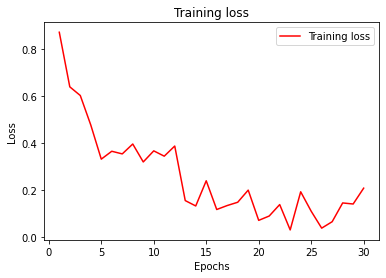

In [11]:
plt.plot(range(1, NUM_EPOCHS+1), cost_epoch, 'r', label='Training loss')
#plt.plot(NUM_EPOCHS, acc_epoch, 'b', label='Accuracy')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

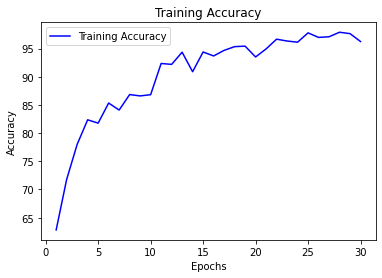

In [12]:
plt.plot(range(1,NUM_EPOCHS+1), acc_epoch, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 88.62%


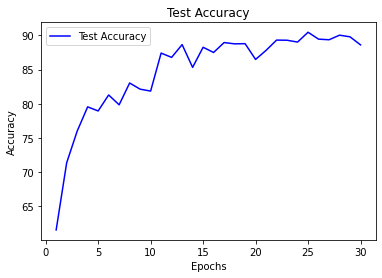

In [14]:
plt.plot(range(1,NUM_EPOCHS+1), acc_epoch_test, 'b', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits, labels = model(features.to(DEVICE))
_, predicted_labels = torch.max(labels, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


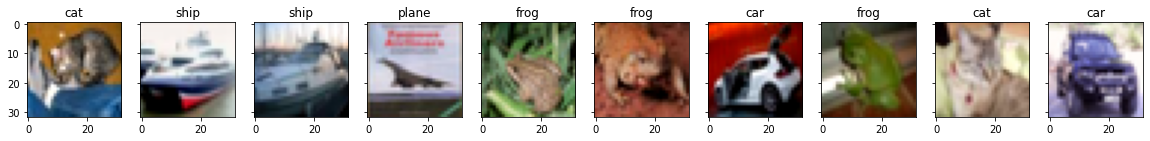

In [16]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


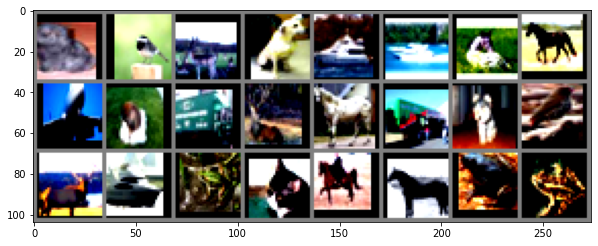

In [27]:
import torchvision

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.figure(figsize=[10, 10])
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=[10, 10])
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[:24])

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
#writer.add_image('CIFAR10', img_grid)

In [31]:
from torchvision import models
from summary import summary

vgg = models.vgg16()
summary(vgg, (3, 224, 224))


ModuleNotFoundError: ignored